In [111]:
import pandas as pd
import numpy as np
import baltic as bt
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid', font_scale=1.5, palette='Paired')

In [10]:
######  CONFIG; EDIT ME  #####

# Pull pre-computed clade frequencies
dataset_name = 'SEAsia'
out_path = '../../data/titer-model/frequencies/'
frequency_path = '../../data/titer-model/frequencies/southeast_asia_clade_frequencies.csv'

# these are identical trees, but with `dTiter` values assigned by the titer model either to 
# all/any branch in the tree, or restricted to branches between serotypes
all_branch_effects_tree = '../../data/titer-model/all-branch-effects/jsons/dengue_all_tree.json' 
interserotype_branch_effects_tree = '../../data/titer-model/interserotype-branch-effects/jsons/dengue_all_tree.json'

# the node IDs ("clade" trait from augur) of the MRCAs of 
# all antigenically uniform clades (as determined by cTiter values in the all branch effects tree)
uniform_cTiter_clades = [str(i) for i in [4, 33, 117, 495, 975, 980, 996, 1017, 1020, 1033, 1089, 
                         1386, 1395, 1454, 1588, 1594, 1860, 2027, 2037, 2119, 
                         2167, 2173, 2185, 2230, 2238, 2588] ]

serotype_clades = [str(i) for i in [1859,1,1385,974] ] # serotype MRCAs
genotype_clades = [str(i) for i in [2185,2589,2238,2596,1460,1393,1587,1455,975,979,1089,33,497,117,543,4,638] ] # canonical genotype MRCAs

date_range = (1970., 2015.) # informative date range
years_back = 3 # how many years before the season of interest to look at past circulation
years_forward = 5 # how many years in the future to predict


sigma = -0.15
gamma = -0.25

In [5]:
##### Input and setup #####

frequencies = pd.read_csv(frequency_path, index_col=0)
frequencies = frequencies.loc[(frequencies.index >= date_range[0]) & (frequencies.index <= date_range[1])]

timepoints = frequencies.index.tolist()
n_years = int(timepoints[-1]) - int(timepoints[0]) # numer of years in the frequencies dataset
tppy = len(timepoints)/n_years # pivots per year

tp_back = years_back*tppy # number of timepoints to sum over
tp_forward = years_forward*tppy # number of timepoints forward to look at

## Load both trees from JSON
all_branch_effects_tree = bt.loadJSON(all_branch_effects_tree, json_translation={'name': 'strain', 'height': 'xvalue'})
interserotype_branch_effects_tree = bt.loadJSON(interserotype_branch_effects_tree, json_translation = {'name': 'strain', 'height': 'xvalue'})

## { clade_ID_number: bt.node object }
all_branch_effects_clade_lookup = {str(k.traits['clade']) : k for k in all_branch_effects_tree.Objects}
interserotype_branch_effects_clade_lookup = {str(k.traits['clade']):k for k in interserotype_branch_effects_tree.Objects}

## check the trees are identical and copy the interserotype_dTiter values 
## so we can access both models' estimates in the same structure
for clade, k in all_branch_effects_clade_lookup.items():
    compare = interserotype_branch_effects_clade_lookup[clade]
    assert k.traits['strain'] == compare.traits['strain']
    
    k.traits['interserotype_dTiter'] = compare.traits['dTiter']
    
clade_lookup = all_branch_effects_clade_lookup # This tree now contains both dTiter measurements for each branch
titer_tree = all_branch_effects_tree

In [9]:
##### Calculate antigenic distance #####

precomputed_titers = defaultdict(dict) 

def are_homotypic(clade1, clade2, clade_lookup=clade_lookup):
    k1, k2 = clade_lookup[clade1], clade_lookup[clade2]
    sero1, sero2 = k1.traits['strain'].split('_')[0], k2.traits['strain'].split('_')[0]
    return sero1==sero2
        
def get_dTiter(clade1, clade2, antigenic_resolution, clade_lookup=clade_lookup):
    '''Calculates dTiter under several different models, indicated as antigenic_resolution arg.
    * 'serotype': sum dTiter on each branch of the interserotype-only tree between clade1 and clade 2
    * 'genotype': sum dTiter on each branch of the all-branch-effects tree between clade1 and clade 2
    * 'null': all strains are antigenically uniform, return 0.
    * 'binary': all strains within a serotype are antigenically uniform, return 0.; all strains between serotypes are equally different, return 1.
    '''
    
    clades = tuple(sorted([clade1, clade2])) # sorted to avoid key errors
    
    try:
        return precomputed_titers[antigenic_resolution][clades]
    except KeyError:
        pass
    
    if antigenic_resolution == 'null' or clade1 == clade2:
        return 0.
    elif antigenic_resolution == 'binary': 
        return float(are_homotypic(clade1, clade2))
    elif antigenic_resolution == 'serotype':
        tree_trait = 'interserotype_dTiter'
    elif antigenic_resolution == 'clade':
        tree_trait = 'dTiter'
    else:
        raise AssertionError, "ERROR: Valid antigenic resolutions are ['serotype', 'clade', 'binary', 'null']. Got: ", antigenic_resolution

    k1, k2 = clade_lookup[clade1], clade_lookup[clade2] # pull bt node objects from the tree
    k1_trace = []
    k2_trace = []
    k = k1 ## Trace from the node 1 to the root (in order)
    while k.index != 'Root':
        k1_trace.append(k)
        k = k.parent
    k = k2 ## Start tracing from node2 to the root; break when we find the first node that's shared along node1's path
    while k not in k1_trace:
        k2_trace.append(k)
        k = k.parent
    else: # first shared node is the Most Recent Common Ancestor (MRCA)
        mrca = k
    shared_k1_trace = k1_trace[:k1_trace.index(mrca)]
    k2_trace.reverse() # walk back down from the mrca, so the path is unidirectional (doesn't matter, but makes my type-A brain happy)
    total_trace = [] # verbose for clarity
    total_trace += shared_k1_trace
    total_trace += k2_trace

    dTiter = sum([k.traits[tree_trait] for k in total_trace]) # sum up dTiter values along the path between clade1 and clade2
    dTiters[antigenic_resolution][clades] = dTiter # save for later
    
    return dTiter

In [37]:
###### Calculate antigenic fitness #######

def waning(gamma, n):
    return max(gamma*n + 1., 0.)

def probability_protection(sigma, titer):
    return max(sigma*titer + 1., 0.)

def sum_over_j(i, timepoint, cocirculating_clades, antigenic_resolution, frequencies=frequencies, sigma=sigma):
    
    frequency_weighted_protection = 0.
    
    for j in cocirculating_clades:
        
        antigenic_distance = get_dTiter(i, j, antigenic_resolution)
        p_protected = probability_protection(sigma, antigenic_distance)
        j_frequency = frequencies[j][timepoint]
        
        frequency_weighted_protection += p_protected*j_frequency
    return frequency_weighted_protection


def sum_over_t(i, timepoint_of_interest, cocirculating_clades, antigenic_resolution, 
               timepoints=timepoints, tp_back=tp_back,
               frequencies=frequencies, sigma=sigma, gamma=gamma):
    
    tp_idx = timepoints.index(timepoint_of_interest)
    
    t_to_sum = timepoints[tp_idx - tp_back : tp_idx]
    waning_over_time = [ waning(gamma, t - timepoint_of_interest) for t in t_to_sum]
    exposure_over_time = [ sum_over_j(i, t, cocirculating_clades, antigenic_resolution, frequencies, sigma) for t in t_to_sum ]
    
    adjusted_exposure_over_time = [ w * p for (w,p) in zip(waning_over_time, exposure_over_time)]
    return adjusted_exposure_over_time


def calculate_fitness(i, cocirculating_clades, antigenic_resolution, 
               timepoints=timepoints, tp_back=tp_back,
               frequencies=frequencies, sigma=sigma, gamma=gamma):
    
    valid_timepoints = timepoints[tp_back:]
    
    if antigenic_resolution == 'null':
        return { t: 0. for t in valid_timepoints }
    
    population_exposure = { t: sum_over_t(i, t, cocirculating_clades, antigenic_resolution) for t in valid_timepoints}
    fitness = { t: 1. - sum(P) for t,P in population_exposure.iteritems()}
    return fitness

In [95]:
##### Predict frequencies #####

def predict_timepoint(initial_frequency, initial_fitness, years_forward):
    if initial_frequency < 0.1:
        return np.nan
    else:
        return initial_frequency*np.exp(initial_fitness*years_forward)

def predict_all_timepoints(i, cocirculating_clades, antigenic_resolution, 
                           timepoints=timepoints, tp_back=tp_back, tp_forward=tp_forward, 
                           years_forward=years_forward, frequencies=frequencies):

    initial_fitnesses = calculate_fitness(i, cocirculating_clades, antigenic_resolution, 
                                          timepoints, tp_back, tp_forward)
    initial_frequencies = frequencies[i]
    initial_timepoints = timepoints[tp_back: -1*tp_forward]

    predicted_frequencies = { t+years_forward : predict_timepoint(initial_frequencies[t], 
                                                                  initial_fitnesses[t], 
                                                                  years_forward)
                            for t in initial_timepoints}

    return predicted_frequencies

def normalize_frequencies_by_timepoint(all_predicted_frequencies):

    predicted_timepoints = sorted(all_predicted_frequencies.values()[0].keys())
    total_per_timepoint = defaultdict(float)

    for clade, predicted_frequencies in all_predicted_frequencies.iteritems():
        assert sorted(predicted_frequencies.keys()) == predicted_timepoints
        for tp, freq in predicted_frequencies.iteritems():
            if not np.isnan(freq):
                total_per_timepoint[tp] += freq

    normalized_predicted_frequencies = {}
    for clade, predicted_frequencies in all_predicted_frequencies.iteritems():
        normalized_predicted_frequencies[clade] = {}
        for tp, freq in predicted_frequencies.iteritems():
            try:
                normalized_predicted_frequencies[clade][tp] = freq / total_per_timepoint[tp]
            except ZeroDivisionError:
                assert not freq or np.isnan(freq), freq # is 0 or np.nan
                normalized_predicted_frequencies[clade][tp] = freq

    return normalized_predicted_frequencies


def predict_normalize_all_clades(cocirculating_clades, antigenic_resolution, 
                                timepoints=timepoints, tp_back=tp_back, tp_forward=tp_forward, 
                                years_forward=years_forward, frequencies=frequencies):

    all_predicted_frequencies = { i : predict_all_timepoints(i, cocirculating_clades, antigenic_resolution, 
                                                        timepoints, tp_back, tp_forward, 
                                                        years_forward, frequencies)
                                for i in cocirculating_clades }
    
    normalized_predicted_frequencies = normalize_frequencies_by_timepoint(all_predicted_frequencies)
    return normalized_predicted_frequencies

In [96]:
null_clade_frequencies = predict_normalize_all_clades(genotype_clades, 'null')

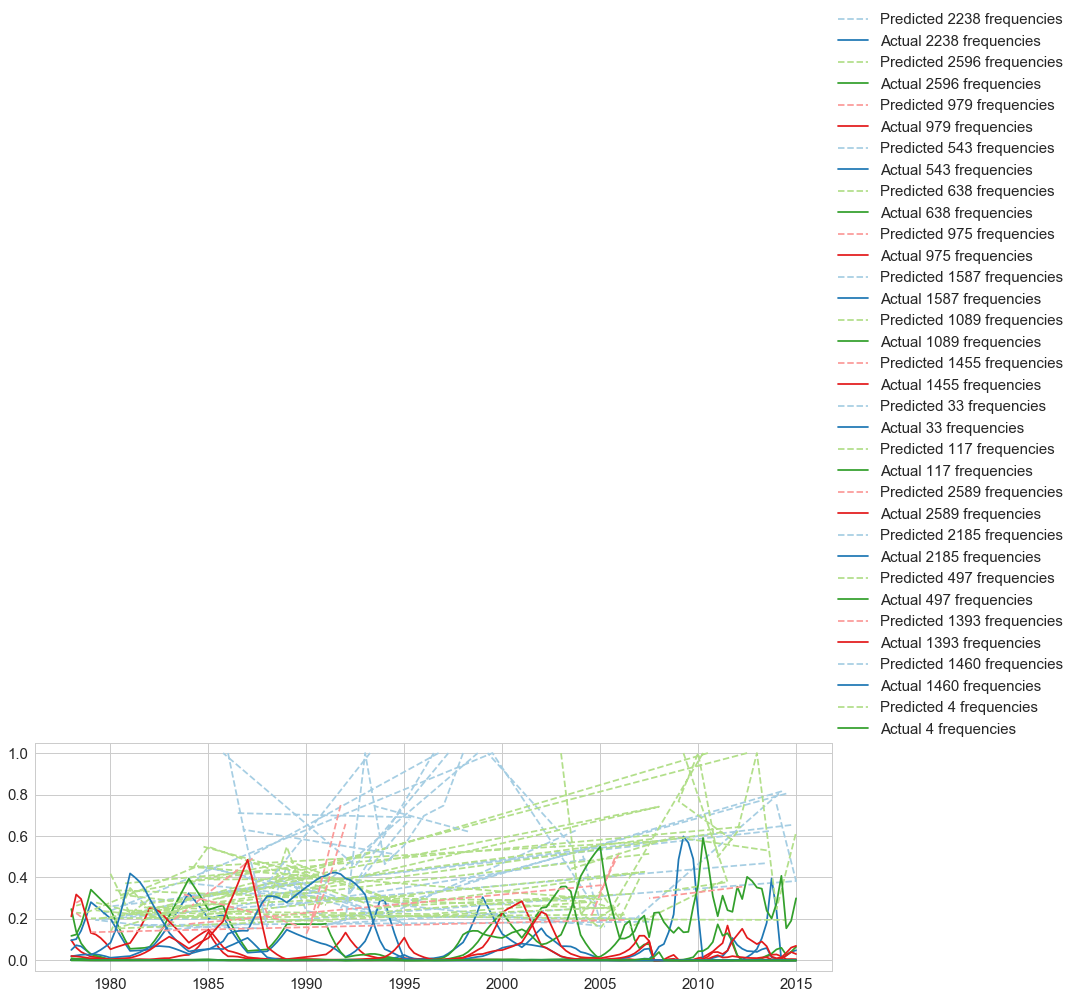

In [115]:
def plot_frequencies(predicted_frequencies, frequencies=frequencies, date_range=date_range):    
    fig, ax = plt.subplots(1,1,figsize=(12,4))
    
    for clade, predicted_freqs in predicted_frequencies.items():
        predicted_date_range = (min(predicted_freqs.keys()), max(predicted_freqs.keys()))
        x,y = zip(*predicted_freqs.items())
        ax.plot(x,y, linestyle='--', label='Predicted %s frequencies'%clade)
        
        actual_frequencies = frequencies[clade][predicted_date_range[0] : predicted_date_range[1]]
        ax.plot(actual_frequencies.index.values, actual_frequencies.values, label='Actual %s frequencies'%clade)
        
    plt.legend(loc=(1,1))
    plt.tight_layout()
    plt.show()
    
plot_frequencies(null_clade_frequencies)

In [ ]:
print np.nan + 0.2

In [ ]:
plt.plot()